In [22]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import numpy as np
import matplotlib
import tkinter
import matplotlib.pyplot as plt
import random
# matplotlib.use('TkAgg')
# %matplotlib widget
%matplotlib inline 
from PIL import Image
import IPython

import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
from stretch_body.robot import Robot
from scipy.spatial.transform import Rotation
from re1_utils.camera import get_cur_rs_frame
from re1_utils.misc import reset_head_position

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Object Detection**: From yolov7

In [23]:
import sys
sys.path.append('./yolov7/')
from yolov7.predict import load_model, preprocessing, \
    postprocessing, load_config

from re1_utils.objdet_utils import plot_all_boxes


In [24]:
#Load config from yaml
CONFIG_PATH = './yolov7/predict_config.yaml'
config_dict = load_config(CONFIG_PATH)

#Load model, edit yolov7.pt path
model, stride, device = load_model(config_dict, '../yolov7/yolov7.pt')


[INFO] [utils.torch_utils]: YOLOR 🚀 a0bbdb1 torch 1.12.1+cu102 CPU



Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


[INFO] [utils.torch_utils]: Model Summary: 306 layers, 36905341 parameters, 36905341 gradients


Read sample img

In [25]:
#Read img0 to BGR
img0 = cv2.imread('./yolov7/inference/images/image1.jpg')
# img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
#Resize, pad
img = preprocessing(config_dict, img0, stride, device) 

#Inference
pred = model(img, augment=config_dict['augment'])[0] #Shape (1, num_preds, 85)

#nms and scale coordinates
pred = postprocessing(config_dict, pred, img0.shape, img.shape)

#xyxy, conf_score, class
print(pred, pred.shape)

[[        250          78         633         531     0.96753           0]
 [          2           5         402         527     0.95566           0]
 [        196         199         254         418     0.88187          27]
 [        256         207         299         247     0.42756          55]] (4, 6)


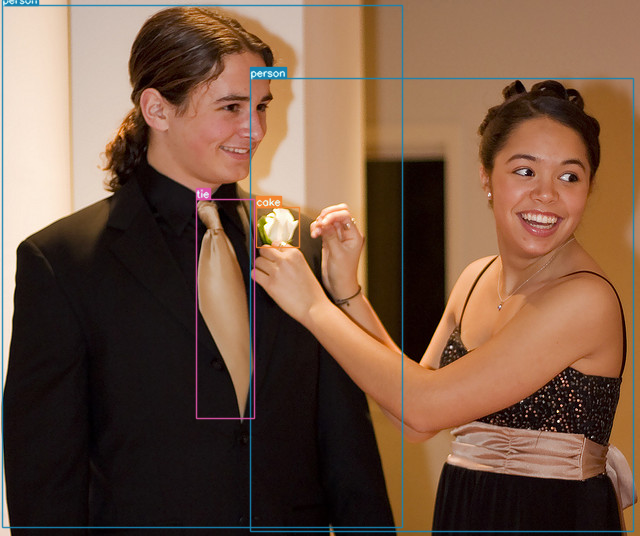

In [26]:
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

plot_all_boxes(pred, img0)
# plt.imshow(img0)
# plt.show()

# img = Image.fromarray(img0, 'RGB')
# img.show()


IPython.display.display(Image.fromarray(img0))



Moving camera position

In [27]:
from re1_utils.misc import move_head 
from math import radians
reset_head_position()
move_head('head_tilt',radians(-20) )

Getting color and depth frame out of camera

Frames Captured


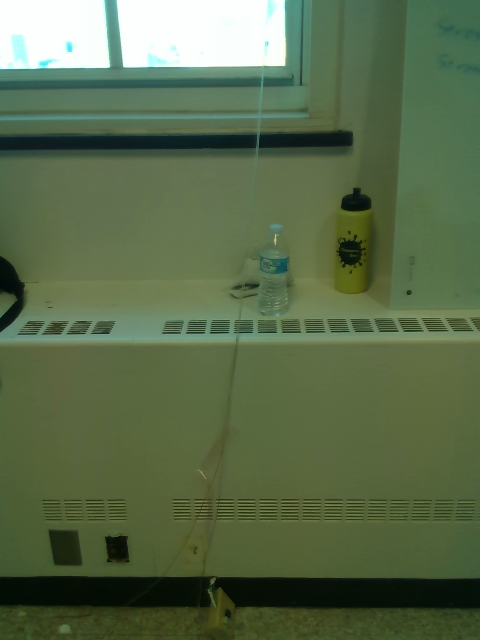

In [30]:
color_frame, color, depth_frame, depth = get_cur_rs_frame()
IPython.display.display(Image.fromarray(color))


Putting image from Robot through yolov7 model \
Output should have shape (n, 6) \
It's (x,y of top left bounding box), (x,y of bottom right bounding box), confidence score, class (see COCO class)

[[        258         224         290         317     0.88926          39]
 [        335         188         374         294      0.8014          39]] (2, 6)


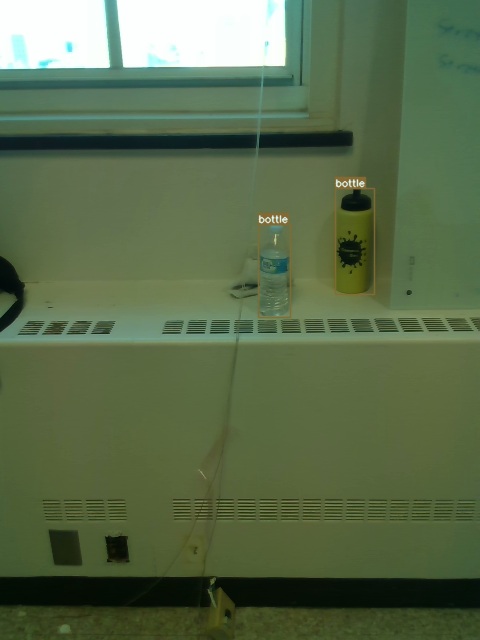

In [31]:
from re1_utils.objdet_utils import plot_all_boxes

#Resize, pad
color_img = preprocessing(config_dict, color, stride, device) 

#Inference
pred = model(color_img, augment=config_dict['augment'])[0] #Shape (1, num_preds, 85)

#nms and scale coordinates
pred = postprocessing(config_dict, pred, color.shape, color_img.shape)

#xyxy, conf_score, class
print(pred, pred.shape)
color = np.ascontiguousarray(color, dtype=np.uint8)

plot_all_boxes(pred, color)
# color_img = Image.fromarray(color, 'RGB')
# color_img.show()
# plt.imshow(color)
# plt.show()
IPython.display.display(Image.fromarray(color))


Coloring the depth frame

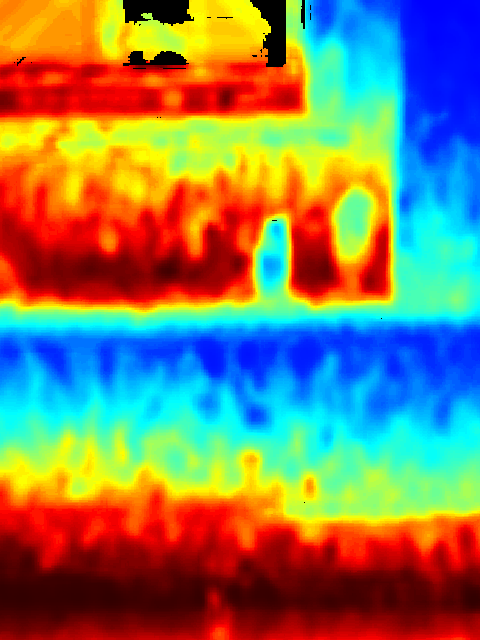

In [32]:
from re1_utils.camera import get_rs_colorized_depth
colorized_depth = get_rs_colorized_depth(depth_frame=depth_frame)
# depth_img = Image.fromarray(colorized_depth, 'RGB')
# depth_img.show()
# plt.imshow(colorized_depth)
# plt.show()
IPython.display.display(Image.fromarray(colorized_depth))


**Testing landmark screen**

In [33]:
from re1_utils.camera import get_cur_rs_frame
color_frame, color, depth_frame, depth = get_cur_rs_frame()
color = np.ascontiguousarray(color, dtype=np.uint8)


Frames Captured


Calling LandmarkScreen to populate the image with OOIs. \
With show(), it saves the image in sample/selection_output.png \
With show_OOI(), it list the objects' image coordinates and depth

In [34]:
from POI.landmark_screen import LandmarkScreen


landmark_screen = LandmarkScreen(color_frame=color, depth_frame=depth)
landmark_screen.update_OOI(pred)
landmark_screen.show()
landmark_screen.show_OOI()

bottle id_0 at ((258, 224), (290, 317)) depth 1.471116304397583 meters
bottle id_1 at ((335, 188), (374, 294)) depth 1.4775651693344116 meters


**Test Intrinsic Matrix**

Get intrinsic matrix and inverse intrinsic matrix from pyrealsense

In [36]:
#Test intrinsic matrix
from re1_utils.camera import get_rs_intrinsic_mat
intrinsic_mat = get_rs_intrinsic_mat()
print(intrinsic_mat)
inv_intrinsic_mat = np.linalg.inv(intrinsic_mat)
print(inv_intrinsic_mat)


[[     606.46           0      323.98]
 [          0       606.4      234.81]
 [          0           0           1]]
[[  0.0016489           0     -0.5342]
 [          0   0.0016491    -0.38722]
 [          0           0           1]]


Update camera coordinates for all OOIs with inverse intrinsic matrix \
Converting image coordinates to camera coordinates

In [37]:
from POI.landmark_screen import LandmarkScreen

landmark_screen.update_cam_coords(inv_intrinsic_mat)

Testing get_OOI()

In [42]:
#Please edit index
bottle0 = landmark_screen.get_OOI()[0]
bottle0.show()
bottle1 = landmark_screen.get_OOI()[1]
bottle1.show()

bottle id_0 at ((258, 224), (290, 317)) depth 1.471116304397583 meters
bottle id_1 at ((335, 188), (374, 294)) depth 1.4775651693344116 meters


**Test extrinsic matrix**

In [43]:
#Test intrinsic matrix
from re1_utils.camera import get_rs_extrinsic_mat
extrinsic_mat = get_rs_extrinsic_mat(type = 'cam2world')
print(extrinsic_mat)

[[     0.9384           0     0.34554           0]
 [          0           1           0           0]
 [   -0.34554           0      0.9384      1.2703]
 [          0           0           0           1]]


Getting extrinsic matrix to transfrom cam_coordinate to base_coordinate \
For all OOI

In [44]:
from POI.landmark_screen import LandmarkScreen

landmark_screen.update_base_coords(extrinsic_mat)

Listing each objects' img coord, temp_cam_coord, cam_coord, base_coord \
See COORD_SYSTEM.md for more details

In [45]:
print(bottle0.img_coord,  bottle0.temp_cam_coord, bottle0.cam_coord, bottle0.base_coord)
print(bottle1.img_coord, bottle1.temp_cam_coord, bottle1.cam_coord, bottle1.base_coord)


[274 270   1] [    0.11164     0.09507      1.4711] [     1.4711    -0.09507     0.11164] [     1.4191    -0.09507     0.86669]
[354 241   1] [    0.18279     0.29042      1.4776] [     1.4776    -0.29042     0.18279] [     1.4497    -0.29042     0.93122]


Visualizing landmarks 

In [18]:
landmarks = landmark_screen.get_landmarks()
from POI.viz_coord import Visualizer
viz = Visualizer(landmark_dict=landmarks)


Camera view

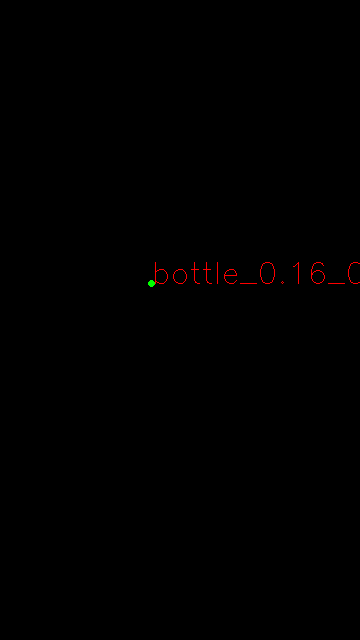

In [19]:
#Camera visualization
viz.viz_cam()


Top down visualization


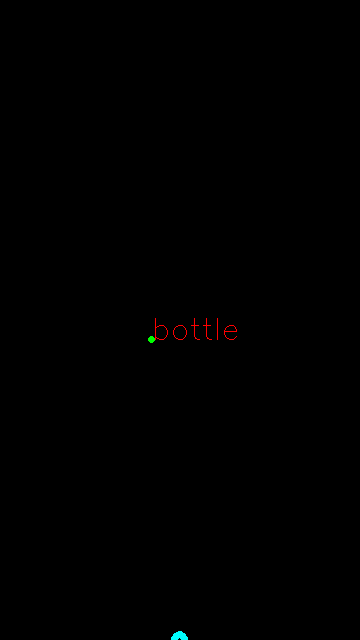

In [20]:
viz.viz_base(coord_type='yz')


For more visualization, see Demo_CoordViz.ipynb

MEMORY

*Taken from fairo tutorial and memory module


**Memory**

Now we have setup a small object detection + deduplication pipeline.

But the robot is not storing the information of these objects in it's memory yet.

If it doesn't store this information in memory, then when you say "go to the chair", it does not know where the chair is (unless the chair is in it's field of view at that given moment).

`droidlet` provides a memory system that can store generic metadata. This memory system is used by the Dialog Parser + Task controller to do tasks utilizing context provided by information stored in memory.

The memory is backed by an SQL database, and has schemas to represent common semantic information for robots and the environment.

Let us first create the default `AgentMemory` object for our Locobot using some pre-baked and thoughtful memory schemas.

In [ ]:
sys.path.append('./memory/')


In [ ]:
from memory.sql_memory import AgentMemory
from memory.robot.loco_memory_nodes import NODELIST

SQL_SCHEMAS = [
    os.path.join(os.getcwd(), "memory", "base_memory_schema.sql"),
    os.path.join(os.getcwd(), "memory", "robot","loco_memory_schema.sql"),
]

In [ ]:
memory = AgentMemory(db_file=":memory:", schema_paths=SQL_SCHEMAS, nodelist=NODELIST)

We can see the types of nodes that can be stored inside the memory

In [ ]:
memory.nodes

Let us store the previously detected objects into memory, using this new memory system.

For this, we will use the DetectedObjectNode. A physical object is represented in memory as a DetectedObjectNode, which is thoughtfully annotated with properties such as it's color and it's detected xyz location.

As a reminder, in the previous section, we deduplicated the objects detected in the scene, and stored them in the variable previous_objects.

Now, we will store these all_objects into the memory. Let us start with storing and retreiving one object, and inspecting the results.

In [ ]:
# from memory.robot.loco_memory_nodes import Detect
from memory.robot.loco_memory_nodes import BCIDetectedObjectNode


In [ ]:
memory_ids = []
for i in range(len(all_objects)):
    memory_id = BCIDetectedObjectNode.create(memory, all_objects[i])
    memory_ids.append(memory_id)

Now, let us retreive the `DetectedObjectNode` from memory.

In [ ]:
memory.get_mem_by_id(memory_id)

The memory object is in it's raw packed form, and is not yet converted back to a dict with accessible fields.

We can access the detected objects back from memory as dicts using the `get_all` function:

In [ ]:
BCIDetectedObjectNode.get_all(memory)

Now, let us store the rest of the detected objects into memory